# Laboratorio 6 – **Avance (Partes 1 a 3)**
**Curso:** CC3066 – Data Science  
**Tema:** Análisis de redes sociales (Twitter/X)  
**Dataset:** `traficogt.txt` o `tioberny.txt` (uno de los dos)  

---
## Estructura del notebook
- **Parte 1. Descarga/Carga de datos** (desde archivos .txt línea-por-línea con JSON)
- **Parte 2. Exploración inicial (estructura JSON y conteos básicos)**
- **Parte 3. Limpieza, preprocesamiento y representación de interacciones (grafo dirigido)**

> Este cuaderno está listo para ejecutar **sin dependencias externas**. Implementa detección robusta de *encoding*,
limpieza de texto, normalización de usuarios/ menciones, eliminación de duplicados, extracción de **menciones**, **retweets** y **respuestas**, y la creación de una estructura de datos y un grafo dirigidos.

## 🔧 Configuración

In [1]:

DATA_FILE = "traficogt.txt"


import os
assert os.path.exists(DATA_FILE), f"No se encontró el archivo: {DATA_FILE}"
print("Usando archivo:", DATA_FILE)

Usando archivo: traficogt.txt


## 🧰 Utilidades

In [2]:
import json, re, unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict

def try_open_detect_encoding(path, encodings=("utf-8", "utf-8-sig", "utf-16", "latin-1")):
    """
    Intenta abrir el archivo con varios encodings y valida que las primeras líneas
    sean JSON. Devuelve el encoding elegido.
    """
    for enc in encodings:
        try:
            with open(path, "r", encoding=enc, errors="strict") as f:
                for i, line in enumerate(f):
                    if not line.strip():
                        continue
                    try:
                        json.loads(line.strip())
                        return enc
                    except Exception:
                        if i > 5:
                            break
        except Exception:
            pass
    return "latin-1"

# Stopwords básicas en español (compactas, sin depender de internet)
SP_STOPWORDS = set('''a al algo algunas algunos ante antes como con contra cual cuales cuando de del desde donde dos el
ella ellas ellos en entre era erais eramos eran es esa esas ese eso esos esta estaba estabais estabamos estaban
estan estar este estes estos esta estas fue fueron fui fuimos ha haber habia habiais habiamos habian han hasta hay
la las le les lo los mas me mi mia mias mientras mio mios mis mucho muy nada ni no nos nosotras nosotros nuestra
nuestras nuestro nuestros nunca o os otra otras otro otros para pero poco por porque que quien quienes se sin sobre
soy su sus te tuvo tuve tuvieron tuvimos tuya tuyas tuyo tuyos un una uno unas unos usted ustedes ya y'''.split())

def clean_text(text, remove_numbers=True, remove_stopwords=True):
    if not isinstance(text, str):
        return ""
    s = text.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)  # urls
    s = re.sub(r"@\w+", " ", s)                # menciones
    s = re.sub(r"#\w+", " ", s)                # hashtags
    s = unicodedata.normalize("NFKD", s)
    if remove_numbers:
        s = re.sub(r"[^a-záéíóúñü\s]", " ", s)
    else:
        s = re.sub(r"[^a-z0-9áéíóúñü\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    if remove_stopwords:
        tokens = [t for t in s.split() if t not in SP_STOPWORDS]
        s = " ".join(tokens)
    return s

def author_screen_name(row):
    u = row.get("user", {})
    sn = u.get("screen_name") if isinstance(u, dict) else None
    if isinstance(sn, str):
        return sn.lower()
    return None

def extract_mentions(row):
    ents = row.get("entities", {})
    ums = ents.get("user_mentions", []) if isinstance(ents, dict) else []
    return [m.get("screen_name", "").lower() for m in ums if isinstance(m, dict) and m.get("screen_name")]

def extract_retweet_user(row):
    rs = row.get("retweeted_status")
    if isinstance(rs, dict):
        u = rs.get("user", {})
        return (u.get("screen_name") or "").lower()
    return None

## Parte 1. **Carga de datos**

In [3]:
encoding = try_open_detect_encoding(DATA_FILE)
print("Encoding detectado:", encoding)

tweets = []
with open(DATA_FILE, "r", encoding=encoding, errors="ignore") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            tweets.append(json.loads(line))
        except Exception:
            pass

print(f"Total de tweets cargados: {len(tweets)}")
assert len(tweets) > 0, "No se pudieron cargar tweets. Verifica el archivo y su codificación."

df = pd.DataFrame(tweets)
print("Columnas detectadas (primeras 25):\n", sorted(df.columns.tolist())[:25])
df["author"] = df.apply(author_screen_name, axis=1)
display(df.head(3))

Encoding detectado: utf-16
Total de tweets cargados: 815
Columnas detectadas (primeras 25):
 ['_type', 'bookmarkedCount', 'card', 'cashtags', 'conversationId', 'conversationIdStr', 'coordinates', 'date', 'hashtags', 'id', 'id_str', 'inReplyToTweetId', 'inReplyToTweetIdStr', 'inReplyToUser', 'lang', 'likeCount', 'links', 'media', 'mentionedUsers', 'place', 'quoteCount', 'quotedTweet', 'rawContent', 'replyCount', 'retweetCount']


,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type,author
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,None
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet,None
2,1834039491826180424,1834039491826180424,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,"{'id': 1730828822029750272, 'id_str': '1730828...",qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,...,NaN,None,"{'id': 130315077, 'id_str': '130315077', 'user...","<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,None


## Parte 2. **Exploración inicial**

In [8]:
n_tweets = len(df)
unique_authors = df["author"].dropna().unique().tolist()

print("Tweets totales:", n_tweets)
print("Autores únicos:", len(unique_authors))

possible_cols = ["text", "lang", "created_at", "favorite_count", "retweet_count", "in_reply_to_screen_name", "entities", "retweeted_status"]
present = [c for c in possible_cols if c in df.columns]
print("Campos clave presentes:", present)

ex = df.iloc[0].to_dict()
print("\nEjemplo 'entities':", ex.get("entities"))
print("Ejemplo 'retweeted_status' presente:", "retweeted_status" in ex)

Tweets totales: 815
Autores únicos: 0
Campos clave presentes: ['lang']

Ejemplo 'entities': None
Ejemplo 'retweeted_status' presente: False
Tweets totales: 815
Autores únicos: 0
Campos clave presentes: ['lang']

Ejemplo 'entities': None
Ejemplo 'retweeted_status' presente: False


## Parte 3. **Limpieza, preprocesamiento y representación de interacciones**

**Checklist de limpieza implementada:**
- Conversión a **minúsculas**
- Eliminación de **URLs**
- Eliminación de **menciones** (`@usuario`) y **hashtags** (`#tema`) de la cadena de texto
- Normalización **Unicode**
- Remoción de **signos de puntuación** y **caracteres especiales**
- Opción para remover **números**
- Remoción de **stopwords (español)** sin depender de internet
- **Eliminación de duplicados** de texto limpio
- **Normalización de usuarios/ menciones** en minúsculas

**Interacciones extraídas (grafos dirigidos):**
- **Mención**: `autor -> mencionado`
- **Retweet**: `autor -> autor_original`
- **Respuesta**: `autor -> destinatario_respuesta`

In [9]:
# 1. Autor
def author_screen_name(row):
    u = row.get("user", {})
    if isinstance(u, dict):
        return u.get("username", "").lower()
    return None

df["author"] = df.apply(author_screen_name, axis=1)

# 2. Menciones
def extract_mentions(row):
    mus = row.get("mentionedUsers", [])
    return [m.get("username", "").lower() for m in mus if isinstance(m, dict) and m.get("username")]

df["mentions"] = df.apply(extract_mentions, axis=1)

# 3. Respuestas
def extract_reply_to(row):
    ru = row.get("inReplyToUser", {})
    if isinstance(ru, dict):
        return ru.get("username", "").lower()
    return None

df["reply_to"] = df.apply(extract_reply_to, axis=1)

# 4. Construcción de interacciones
edges = []
for _, row in df.iterrows():
    src = row["author"]
    if not src:
        continue
    # Menciones
    for m in row["mentions"]:
        if m and m != src:
            edges.append((src, m, "mention"))
    # Respuesta
    if row["reply_to"] and row["reply_to"] != src:
        edges.append((src, row["reply_to"], "reply"))

edges_df = pd.DataFrame(edges, columns=["source", "target", "type"]).drop_duplicates()
print("Usuarios únicos:", len(set(edges_df["source"]).union(set(edges_df["target"]))))
print("Interacciones totales:", len(edges_df))
display(edges_df.head())


Usuarios únicos: 628
Interacciones totales: 1637


,source,target,type
0,monymmorales,cc_guatemala,mention
1,animaldgalaccia,pncdeguatemala,mention
2,animaldgalaccia,mingobguate,mention
3,animaldgalaccia,fjimenezmingob,mention
4,animaldgalaccia,diegoedeleon,mention


### Matriz de adyacencia (conteo por usuario → usuario)

In [10]:
adj = pd.crosstab(edges_df["source"], edges_df["target"])
print("Dimensión de la matriz de adyacencia:", adj.shape)
display(adj.head(10))

Dimensión de la matriz de adyacencia: (425, 262)


target,21kmuniguate,72_cpineda,__vadertg,_ojoconmipisto,_rahina_,acguatemala,adopcionesguate,aeu_oliveriocdl,agn_noticias,ajutzuy,...,vientomares,volker_turk,voxpopuliguate,vozdeltuit,walterm91033122,wergabriel,wichochicken,yenerplaza,yoeldeleon23,zoom_502gt
source,,,,,,,,,,,,,,,,,,,,,
1994meola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91072dff5a5a4f1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_____das____,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
__vadertg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_jhernandez81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaalonso71,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aacn75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acidogt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adnjernimo1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grafo dirigido (visualización básica)

Nodos: 628 Aristas: 1151


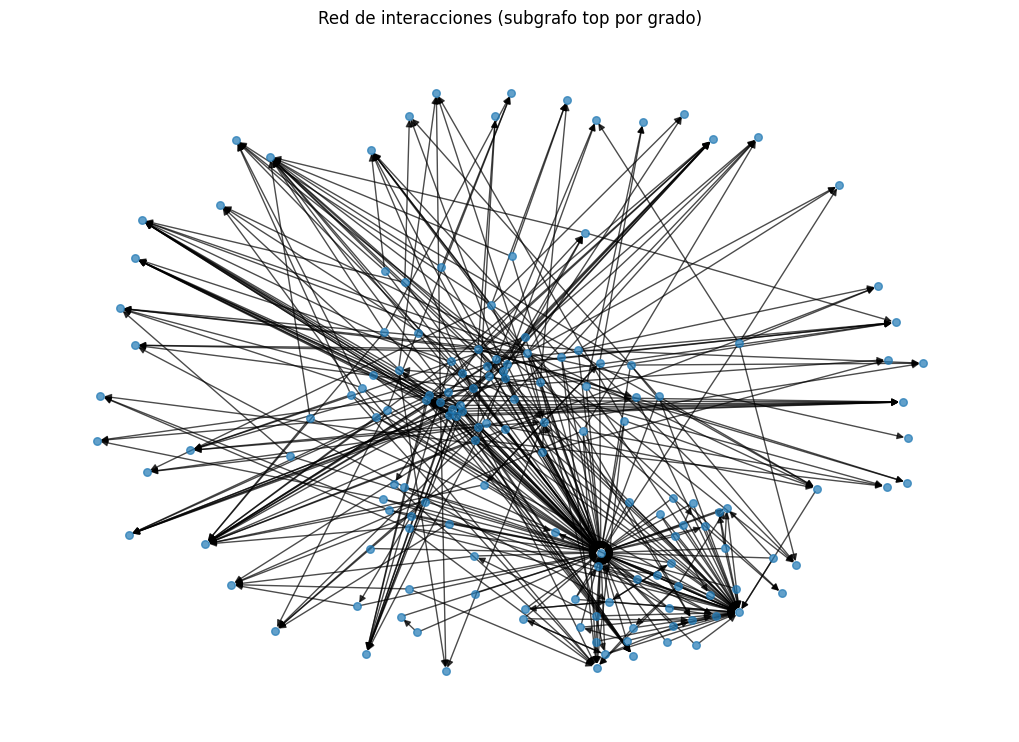

In [11]:
# Construir grafo dirigido con pesos
G = nx.DiGraph()
for (s, t, typ), w in edges_df.value_counts(["source", "target", "type"]).items():
    if G.has_edge(s, t):
        G[s][t]["weight"] += int(w)
    else:
        G.add_edge(s, t, weight=int(w), type=typ)

print("Nodos:", G.number_of_nodes(), "Aristas:", G.number_of_edges())

# Subgrafo de los top-N por grado para visualizar más claramente
N = 150
degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
top_nodes = [n for n, _ in degrees[:N]]
SG = G.subgraph(top_nodes).copy()

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(SG, k=0.35, seed=42)
nx.draw(SG, pos, node_size=30, with_labels=False, alpha=0.7)
plt.title("Red de interacciones (subgrafo top por grado)")
plt.show()